https://huggingface.co/learn/nlp-course/chapter2/1?fw=pt NLP COURSE

In [46]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9598049521446228},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

In [47]:
classifier.model


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [48]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [4]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [21]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model_pretrained = AutoModel.from_pretrained(checkpoint)

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The base transformer model: given some inputs, it outputs what we’ll call hidden states, also known as <b>features</b>. For each model input, we’ll retrieve a high-dimensional vector representing the <b>contextual understanding of that input</b> by the Transformer model.

In [22]:
outputs = model_pretrained(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 16, 768])


In [23]:
inputs['input_ids'].shape

torch.Size([2, 16])

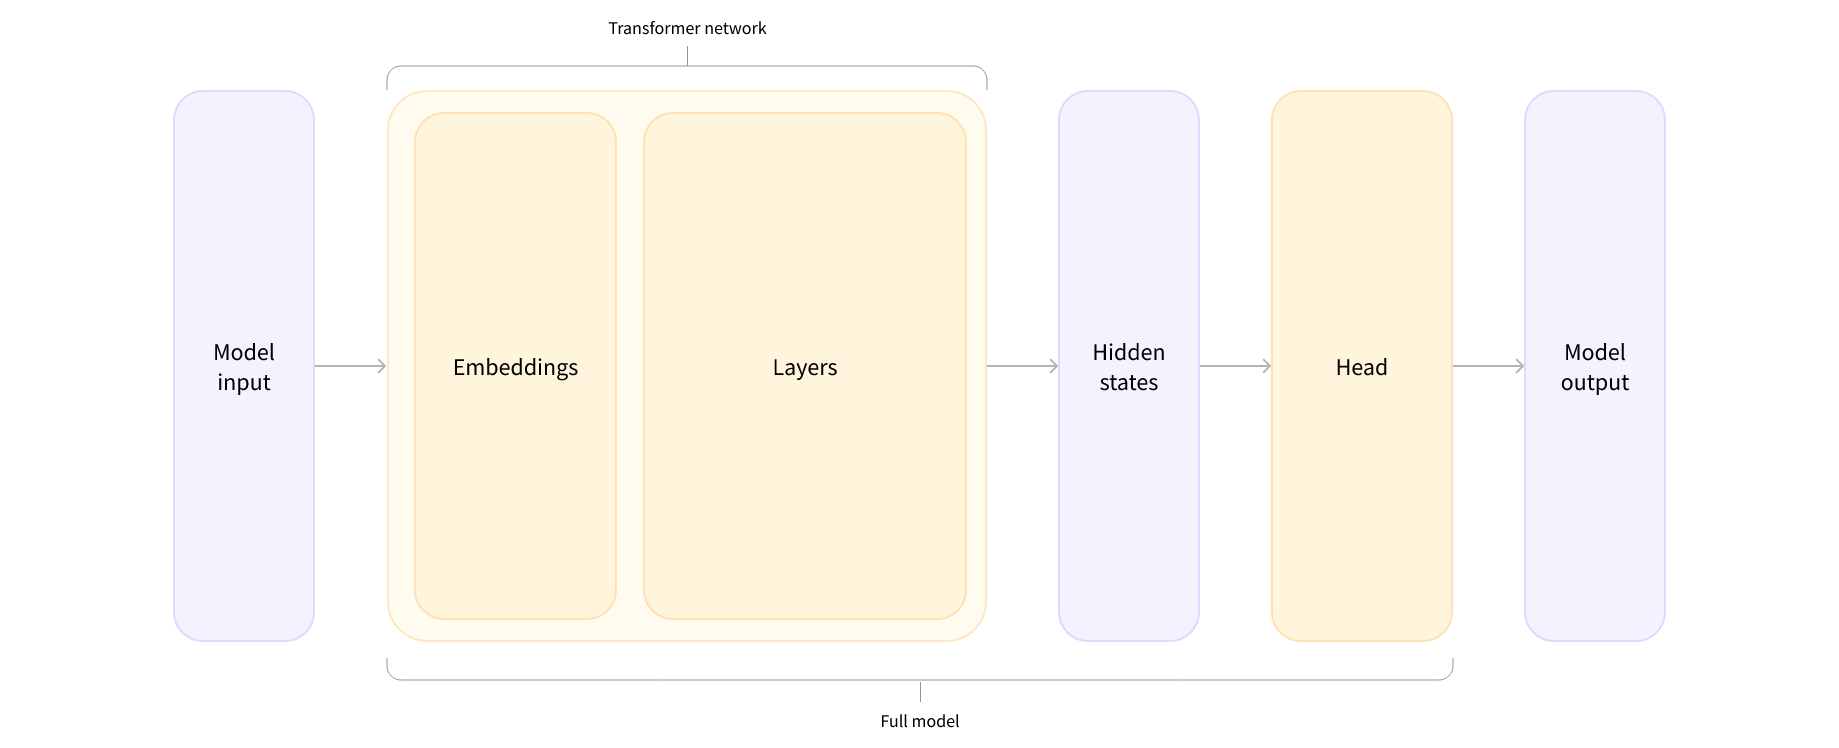
The output of the Transformer model is sent directly to the model head to be processed.

In this diagram, the model is represented by its embeddings layer and the subsequent layers. The embeddings layer converts each input ID in the tokenized input into a vector that represents the associated token. The subsequent layers manipulate those vectors using the attention mechanism to produce the final representation of the sentences.

There are many different architectures available in 🤗 Transformers, with each one designed around tackling a specific task.
Here is a non-exhaustive list:

*Model (retrieve the hidden states)
*ForCausalLM
*ForMaskedLM
*ForMultipleChoice
*ForQuestionAnswering
*ForSequenceClassification
*ForTokenClassification

In [24]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

Now if we look at the shape of our outputs, the dimensionality will be much lower: the model head takes as input the high-dimensional vectors we saw before, and outputs vectors containing two values (one per label):

In [25]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [26]:
outputs.logits.shape

torch.Size([2, 2])

Those are not probabilities but logits, the raw, unnormalized scores outputted by the last layer of the model. To be converted to probabilities, they need to go through a SoftMax layer (all 🤗 Transformers models output the logits, as the loss function for training will generally fuse the last activation function, such as SoftMax, with the actual loss function, such as cross entropy):

In [27]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


In [28]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

Let's get some insights about the embeddings

In [32]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

In [33]:
inputs1 = tokenizer(["The school is over", 
                     "The school building crashed", 
                     "The bank building crashed", 
                     "The book is closed"], return_tensors="pt")

In [49]:
tokenizer.tokenize("the school is over, surprisinglyfinally, Romina is here")

['the',
 'school',
 'is',
 'over',
 ',',
 'surprisingly',
 '##fin',
 '##ally',
 ',',
 'rom',
 '##ina',
 'is',
 'here']

In [35]:
outputs=model_pretrained(**inputs1)

In [45]:
outputs.keys()

odict_keys(['last_hidden_state'])

In [50]:
outputs.last_hidden_state.shape

torch.Size([4, 6, 768])

In [52]:
school_sentence2_vector

tensor([-4.2150e-01,  7.3473e-01, -1.4096e-01, -3.0260e-01, -8.1082e-01,
         9.4644e-01,  6.5572e-01,  1.3687e+00,  4.4381e-01, -8.1860e-02,
         1.6182e-01, -5.5086e-01, -5.6463e-03,  4.1567e-02, -5.2508e-01,
         3.6799e-02,  2.4745e-01, -7.6954e-02,  1.8701e-01,  2.6240e-01,
        -8.4748e-01, -1.6194e-01, -3.8258e-01,  3.1796e-01,  9.9874e-01,
         9.2165e-01, -2.4402e-01,  4.0842e-01, -7.8211e-01,  1.0179e+00,
         1.9996e-01, -1.7463e-01,  8.9299e-01, -9.1823e-03,  4.2311e-01,
        -4.3935e-01, -3.0795e-01, -2.1644e-01, -3.1318e-01,  1.8929e-01,
        -1.2758e+00, -1.3869e-01, -7.0064e-01,  6.9862e-01,  9.2633e-01,
         3.7968e-01,  9.1285e-01, -1.0529e+00, -3.5701e-01, -2.7100e-02,
        -1.6814e+00,  2.4766e-01,  7.3473e-01, -3.7350e-01,  1.4723e-02,
        -2.5606e-01,  2.6029e-01, -6.7150e-01,  6.5714e-01,  7.4698e-01,
         6.4600e-01,  6.5534e-01,  3.5110e-02,  5.3569e-01, -2.3358e-01,
         9.9385e-01,  1.1306e-01, -6.0365e-01, -1.3

In [38]:
school_sentence1_vector = outputs.last_hidden_state[0,2, :]
school_sentence2_vector = outputs.last_hidden_state[1,2, :]
bank_sentence3_vector = outputs.last_hidden_state[2,2, :]
book_sentence4_vector = outputs.last_hidden_state[3,2, :]

In [39]:
cos(school_sentence1_vector, school_sentence1_vector)

tensor(1., grad_fn=<SumBackward1>)

In [40]:
cos(school_sentence1_vector, school_sentence2_vector)

tensor(0.8196, grad_fn=<SumBackward1>)

In [41]:
cos(school_sentence2_vector, bank_sentence3_vector)

tensor(0.8349, grad_fn=<SumBackward1>)

In [42]:
cos(school_sentence1_vector, bank_sentence3_vector)

tensor(0.6996, grad_fn=<SumBackward1>)

In [43]:
cos(school_sentence1_vector, book_sentence4_vector)

tensor(0.7002, grad_fn=<SumBackward1>)

In [44]:
cos(school_sentence2_vector, book_sentence4_vector)

tensor(0.5901, grad_fn=<SumBackward1>)

Pretraining + fine tuning
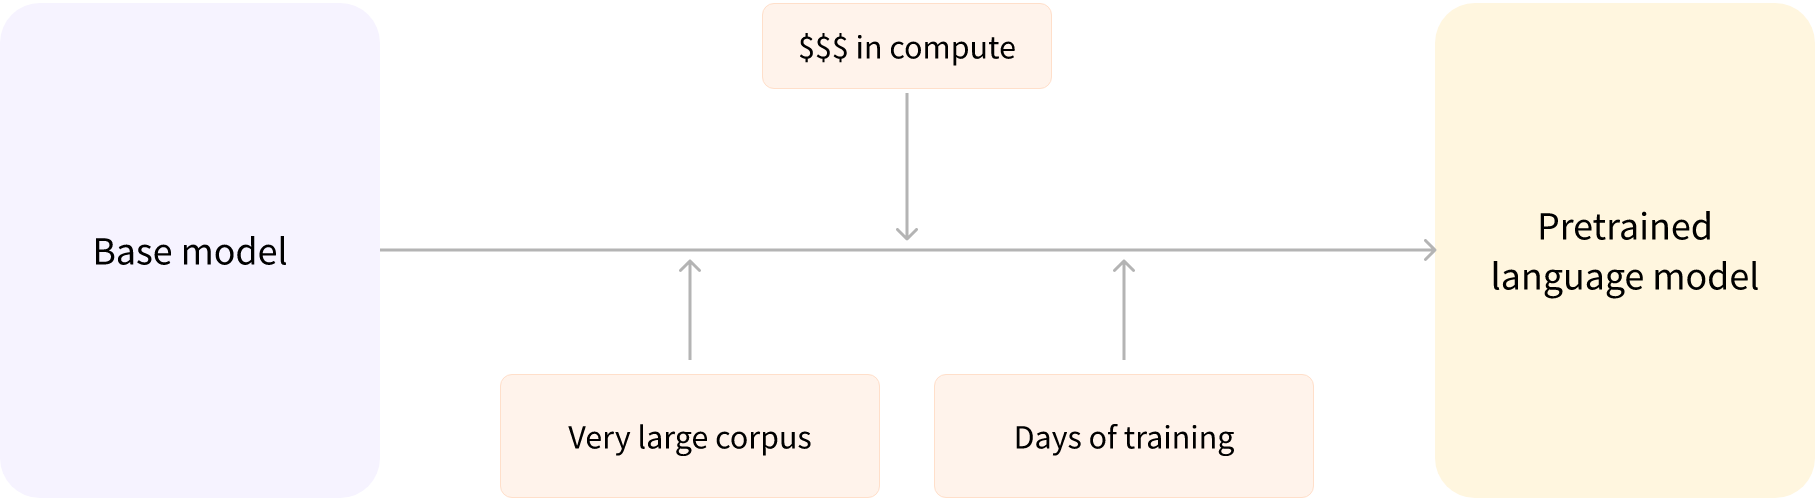
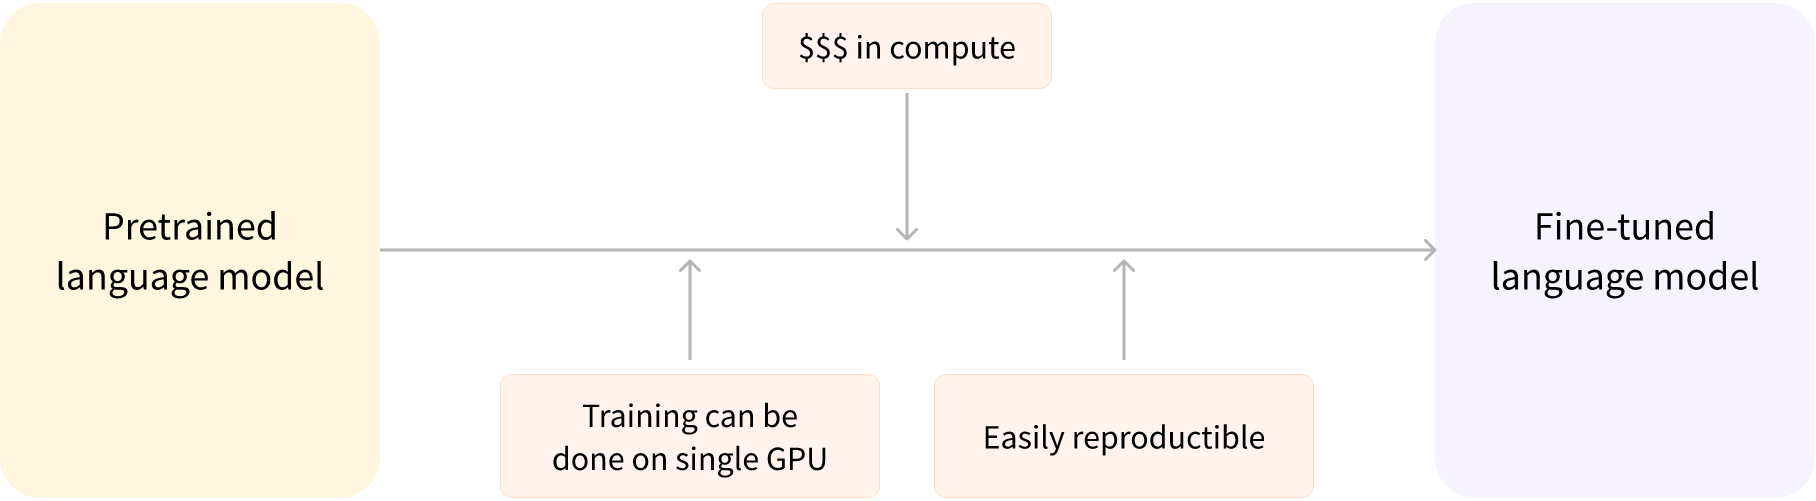